In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Physics-informed regularization: Solving ODEs

## Objectives

+ Learn how to solve ODEs with neural networks.

This notebook replicates some of the results of [Lagaris et al. 1998)](https://arxiv.org/pdf/physics/9705023.pdf).

In [2]:
import torch
import torch.nn as nn

# This is useful for taking derivatives:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

## Example 1: Single ODE

Consider the ode:

$$
\frac{d\Psi}{dx} = f(x, \Psi),
$$

with $x \in [0,1]$ and initial conditions (IC):

$$
\Psi(0) = A.
$$

We write the trial solution by:

$$
\hat{\Psi}(x; \theta) = A + x N(x; \theta),
$$

where $N(x; \theta)$ is a neural network (NN).
The solution is $\hat{\Psi}(x;\theta)$ automatically satisfied the initial conditions.
The loss function we would like to minimize to train the NN is:

$$
L(\theta) = \int_0^1 \left[\frac{d\Psi_t(x;\theta)}{dx} - f(x,\hat{\Psi}(x;\theta))\right]^2dx.
$$

In [3]:
# N is a Neural Network - This is exactly the network used by Lagaris et al. 1997
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Initial condition
A = 0.

# The Psi_t function
Psi_t = lambda x: A + x * N(x)

# The right hand side function
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

# The loss function
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

First, I am going to use the method that we find in Lagaris et al.
Instead of using stochastic optimization, they use a lot of points to estimate the loss integral (I am going to use 100) and then they just do gradient-based optimization (I am going to do BFGS).

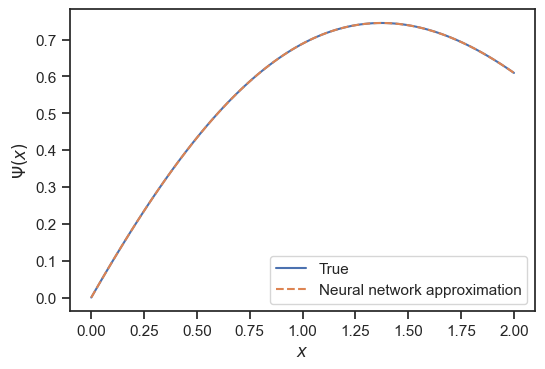

In [4]:
# Optimize (same algorithm as in Lagaris)
optimizer = torch.optim.LBFGS(N.parameters())

# The collocation points used by Lagaris
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

# Run the optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l
    
for i in range(10):
    optimizer.step(closure)

# Let's compare the result to the true solution
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best');

Now, we are going to do the same thing using stochastic gradient descent:

In [5]:
# We need to reinitialize the network
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Let's see now if a stochastic optimizer makes a difference
adam = torch.optim.Adam(N.parameters(), lr=0.01)

# The batch size you want to use (how many points to use per iteration)
n_batch = 5

# The maximum number of iterations to do
max_it = 1000

for i in range(max_it):
    # Randomly pick n_batch random x's:
    x = 2 * torch.rand(n_batch, 1)
    # Zero-out the gradient buffers
    adam.zero_grad()
    # Evaluate the loss
    l = loss(x)
    # Calculate the gradients
    l.backward()
    # Update the network
    adam.step()
    # Print the iteration number
    if i % 100 == 99:
        print(i)

99
199
299
399
499
599
699
799
899
999


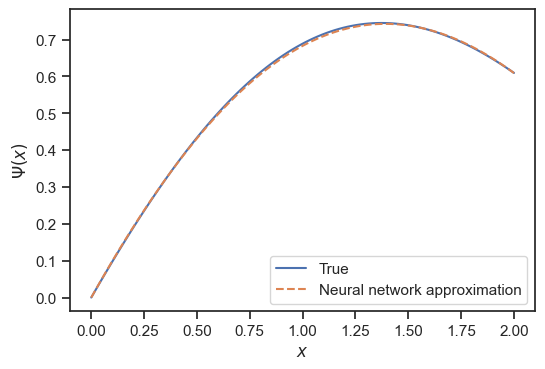

In [6]:
# Let's compare the result to the true solution
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best');

### Questions

In the following questions, just use the stochastic gradient approach.

+ Change `n_batch` to just 1. Does the algorithm work? Did you have to increase the iterations to achieve the same accuracy?
+ Modify the code, so that you now solve the problem for $x$ between 0 and 5. Play with the `n_batch` and `max_it` until you get a good solution.

## Solving any dynamical system with neural networks

Let's write some code that will allow us to solve any dynamical system:

In [7]:
class DynamicalSystem(object):
    """
    A class representing an initial value problem.
    
    :param dim:               The dimensionality of the problem.
    :param rhs:               The right hand side of the equation.
                              This must be a function with signature rhs(t, y)
                              where t is time and y is the state of the system.
    :param init_conditions:   Initial conditions. Must be a vector of dimension dim.
    :param net:               A neural network for representing the solution. This must have
                              one-dimensional input and dim-dimensional output.
    """
    
    def __init__(self, dim, rhs, init_conditions, net):
        assert isinstance(dim, int)
        assert dim > 0
        self._dim = dim
        self._rhs = rhs
        if isinstance(init_conditions, float):
            init_conditions = np.atleast_1d(init_conditions)
        init_conditions = torch.Tensor(init_conditions)
        self._init_conditions = init_conditions
        self._net = net
        self._solution = lambda T: self.init_conditions + T * self.net(T)
        
    @property
    def dim(self):
        return self._dim
    
    @property
    def rhs(self):
        return self._rhs
    
    @property
    def init_conditions(self):
        return self._init_conditions
    
    @property
    def net(self):
        return self._net
    
    @property
    def solution(self):
        """
        Return the solution function.
        """
        return self._solution
    
    def squared_residual_loss(self, T):
        """
        Returns the squared residual loss at times T.
        
        :param T:    Must be a 1D torch tensor.
        """
        T.requires_grad = True
        sol = self.solution(T)
        dsol_dt = torch.empty_like(sol)
        for d in range(self.dim):
            go = torch.zeros_like(sol)
            go[:, d] = 1.0
            dsol_dt[:, d] = torch.autograd.grad(sol, T, grad_outputs=go,
                                                create_graph=True)[0][:, 0]
        return torch.mean((dsol_dt - self.rhs(T, sol)) ** 2.)
    
    def solve_lbfgs(self, T_colloc, max_iter=10):
        """
        Solve the problem by minimizing the squared residual loss.
        
        :param T_colloc: The collocation points used to solve the problem.
        """
        optimizer = torch.optim.LBFGS(self.net.parameters())

        # Run the optimizer
        def closure():
            optimizer.zero_grad()
            l = self.squared_residual_loss(T_colloc)
            l.backward()
            return l
    
        for i in range(max_iter):
            optimizer.step(closure)

In [8]:
# Let's use this class with Problem 2 of Lagaris
ex2 = DynamicalSystem(1,
                      lambda t, y: torch.exp(-t / 5.0) * torch.cos(t) - y / 5.0,
                      0.0,
                      nn.Sequential(nn.Linear(1, 10), nn.Sigmoid(), nn.Linear(10,1, bias=False))
                      )
T_colloc = torch.Tensor(np.linspace(0, 2, 20)[:, None])
ex2.solve_lbfgs(T_colloc)

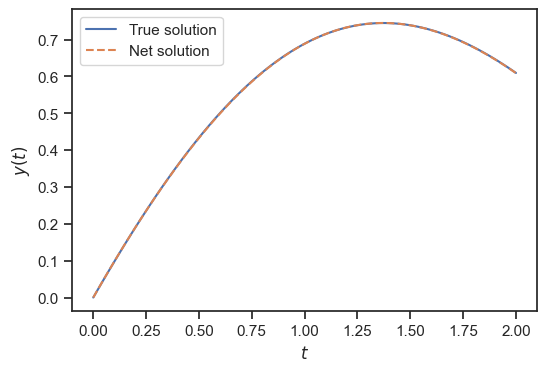

In [9]:
# Now we can evaluate the solution anywhere
T = torch.Tensor(np.linspace(0, 2, 100)[:, None])
sol = ex2.solution(T)
y_true = np.exp(-T / 5.0) * np.sin(T)
fig, ax = plt.subplots(dpi=100)
ax.plot(T.numpy(), y_true.numpy(), label='True solution')
ax.plot(T.numpy(), sol.detach().numpy(), '--', label='Net solution')
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
plt.legend(loc='best');

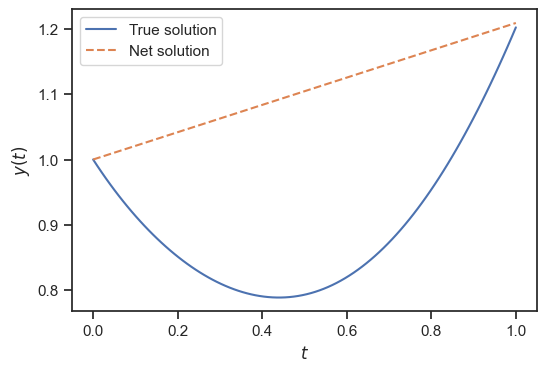

In [10]:
# Here is another problem - Problem 1 of Lagaris
rhs = lambda t, y: t ** 3 + 2 * t + t ** 2 * (1.0 + 3.0 * t ** 2) / (1.0 + t + t ** 3) \
                   -(t + (1.0 + 3.0 * t ** 2) / (1.0 + t + t ** 3)) * y
ex1 = DynamicalSystem(1,
                      rhs,
                      1.0,
                      nn.Sequential(nn.Linear(1, 10), nn.Sigmoid(), nn.Linear(10,1, bias=False))
                      )
T_colloc = torch.Tensor(np.linspace(0, 1, 10)[:, None])
ex1.solve_lbfgs(T_colloc)
T = torch.Tensor(np.linspace(0, 1, 100)[:, None])
sol = ex1.solution(T)
y_true = np.exp( -0.5 * T ** 2) / (1.0 + T + T ** 3) + T ** 2
fig, ax = plt.subplots(dpi=100)
ax.plot(T.numpy(), y_true.numpy(), label='True solution')
ax.plot(T.numpy(), sol.detach().numpy(), '--', label='Net solution')
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
plt.legend(loc='best');

In [11]:
# Let's do a 2D problem - Problem 4 of Lagaris
def rhs(t, y):
    t = torch.flatten(t)
    res = torch.empty_like(y)
    res[:, 0] = torch.cos(t) + y[:, 0] ** 2 + y[:, 1] - (1.0 + t ** 2 + torch.sin(t) ** 2)
    res[:, 1] = 2.0 * t - (1.0 + t ** 2) * torch.sin(t) + y[:, 0] * y[:, 1]
    return res
ex4 = DynamicalSystem(2,
                      rhs,
                      torch.Tensor([0.0, 1.0]),
                      nn.Sequential(nn.Linear(1, 20), nn.Sigmoid(), nn.Linear(20,2, bias=False))
                      )
T_colloc = torch.Tensor(np.linspace(0, 3, 10)[:, None])
ex4.solve_lbfgs(T_colloc, max_iter=20) # Does not work everytime. Sometimes the optimization fails.

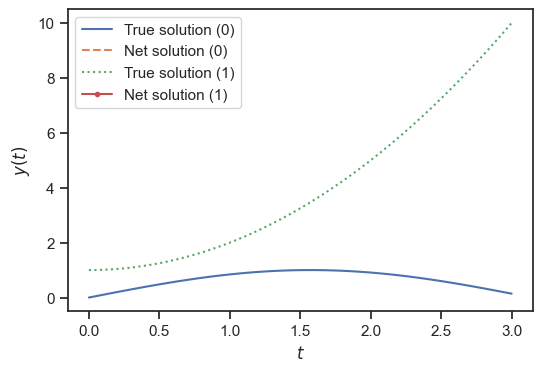

In [12]:
T = torch.Tensor(np.linspace(0, 3, 100)[:, None])
sol = ex4.solution(T)
y1_true = np.sin(T)
y2_true = 1.0 + T ** 2
fig, ax = plt.subplots()
ax.plot(T.numpy(), y1_true.numpy(), label='True solution (0)')
ax.plot(T.numpy(), sol.detach().numpy()[:, 0], '--', label='Net solution (0)')
ax.plot(T.numpy(), y2_true.numpy(), ':', label='True solution (1)')
ax.plot(T.numpy(), sol.detach().numpy()[:, 1], '.-', label='Net solution (1)')
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
plt.legend(loc='best');

### Question

+ Feel free to skip this as it can be hard if you are not expert with Python. Add a method to the class `DynamicalSystem` that uses stochastic gradient descent to solve the same problems. Once you are done, rerun the problems above with your code.